In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import multirtd.utils as utils
from multirtd.zonotope import Zonotope
from multirtd.LPM import LPM
import multirtd.params as params

%load_ext autoreload
%autoreload 2

In [2]:
# System
dt = 0.1
n_s = 4  # State dimension
n_c = 2  # Control dimension
n_m = 2  # Measurement dimension

A = np.eye(n_s)  # Dynamics matrix
A[0:2,2:4] = dt*np.eye(2)
B = np.array([[dt**2/2, 0],  # Control matrix
              [0, dt**2/2],
              [dt, 0],
              [0, dt]])
C = np.array([[1, 0, 0, 0],  # Measurement matrix
              [0, 1, 0, 0]])

Q_LQR = np.eye(n_s)
R_LQR = np.eye(n_c)
K = utils.dlqr_calculate(A, B, Q_LQR, R_LQR)

Q = 0.01

In [3]:
LPM_file = os.path.join(os.getcwd(),'..', 'models', 'quadrotor_linear_planning_model.mat')
lpm = LPM(LPM_file)

LPM FRS Computation

In [4]:
# Peak velocity space
v_max = 3
c_pk = np.zeros((2,1))
G_pk = v_max * np.eye(2)
V_pk = Zonotope(c_pk, G_pk)

# Zeros zonotope
Z0 = Zonotope(np.zeros((2,1)), np.zeros((2,2)))

N = len(lpm.time)  # Trajectory length
P_LPM = lpm.P_mat.T

PRS = N * [None]

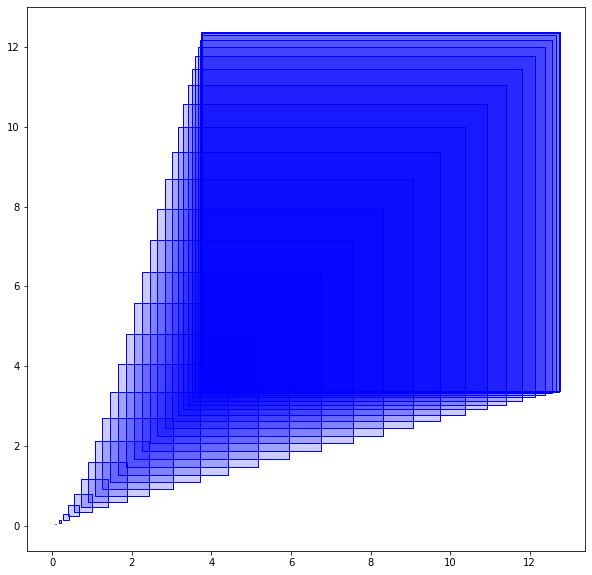

In [5]:
# Fixed initial conditions
v_0 = np.array([4,2])
a_0 = np.array([5,5])
k_0 = np.vstack((v_0, a_0))

p_from_ic = P_LPM[:,1:3] @ k_0

fig, ax = plt.subplots(figsize=(10,10))

v_pk = np.array([1,1])[:,None]

for i in range(N):
    P_from_vpk = P_LPM[i,2] * V_pk
    PRS[i] = P_from_vpk.augment(V_pk) + np.vstack((p_from_ic[i,:][:,None], np.zeros((2,1))))
    PRS[i].view([0,1]).plot(ax)

    PRS_slc = PRS[i].slice([2,3], v_pk)
    PRS_slc.view([0,1]).plot(ax, color='r')

Compute FRS

31


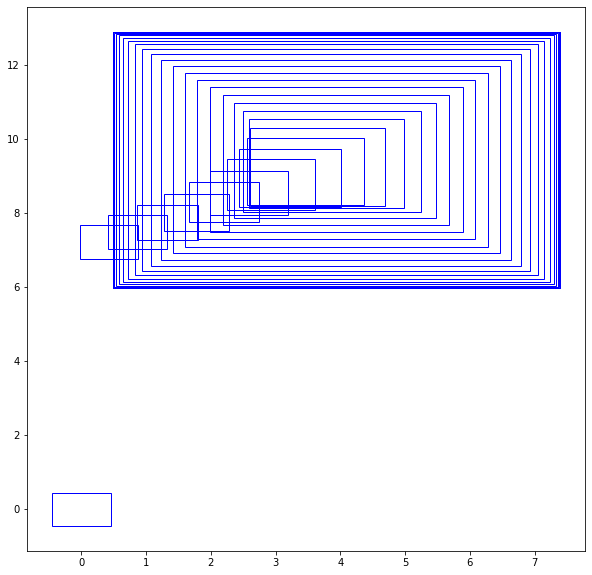

In [64]:
from multirtd.reachability import compute_FRS

# Initial conditions
p_0 = np.array([0,7])[:,None]
v_0 = np.array([4,2])[:,None]
a_0 = np.array([5,5])[:,None]

FRS = compute_FRS(lpm, p_0, v_0, a_0)

fig, ax = plt.subplots(figsize=(10,10))

for Z in FRS:
    Z.view([0,1]).plot(ax, alpha=0.0)

Test slicing

In [7]:
v_pk = np.array([1,1])[:,None]
print(FRS[-1].slice([2,3], v_pk))

Center:
	[[5.438]
	 [3.938]
	 [1.   ]
	 [1.   ]]
Generators:
	[[0.7 0. ]
	 [0.  0.7]
	 [0.  0. ]
	 [0.  0. ]]


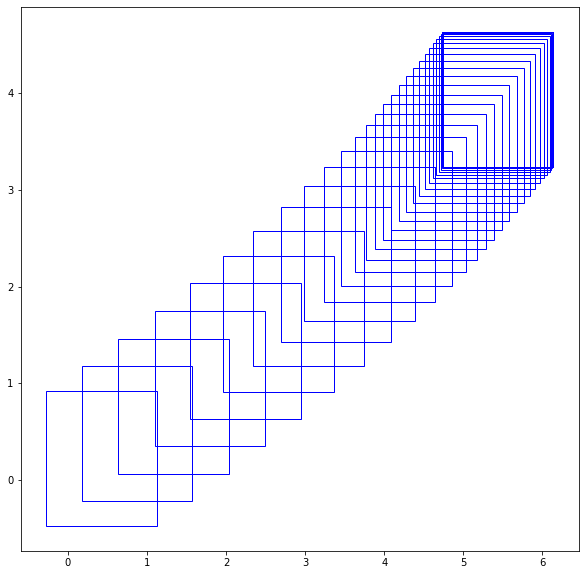

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
v_pk = np.array([1,1])[:,None]

for Z in FRS[1:]:
    Z_slc = Z.slice([2,3], v_pk)
    Z_slc.view([0,1]).plot(ax, alpha=0.0)

Define obstacle

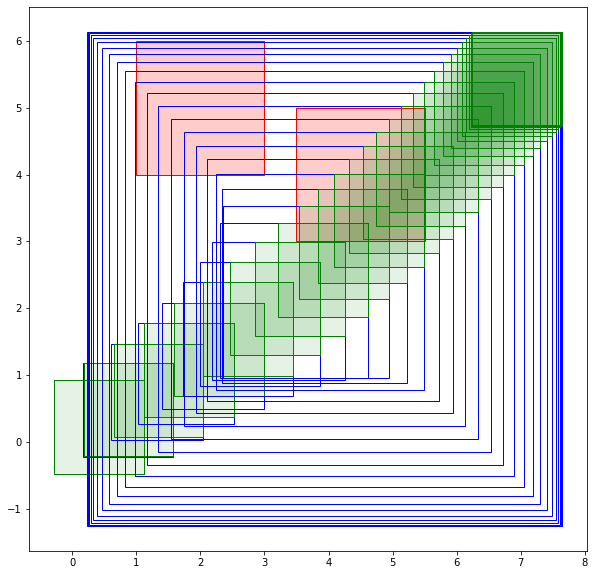

In [59]:
obs_c = np.array([2,5])[:,None]
obs_G = np.eye(2)
obs = Zonotope(obs_c, obs_G)

fig, ax = plt.subplots(figsize=(10,10))

obs.plot(ax, color='r')

obs2_c = np.array([4.5,4])[:,None]
obs2_G = np.eye(2)
obs2 = Zonotope(obs2_c, obs2_G)

obs2.plot(ax, color='r')

for Z in FRS[1:]:
    Z.view([0,1]).plot(ax, alpha=0.0)
    Z_slc = Z.slice([2,3], np.array([x,y])[:,None])
    Z_slc.view([0,1]).plot(ax, color = 'g', alpha=0.1)

Generate collision constraints

In [60]:
from multirtd.reachability import generate_collision_constraints_FRS, check_collision_constraints

# Generate collision constraints
# NOTE: For now, only generate constraints for final element of FRS
nearby_obs = [obs]
#A_con, b_con = generate_collision_constraints(FRS[-1], nearby_obs)
A_con, b_con = generate_collision_constraints_FRS(FRS, nearby_obs)

#A_con2, b_con2 = generate_collision_constraints_FRS(FRS, [obs2])

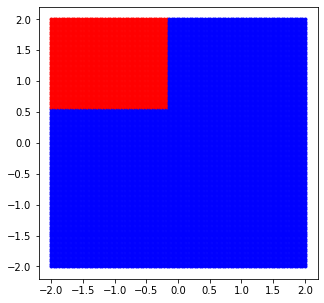

In [61]:
# Plot constraints
fig, ax = plt.subplots(figsize=(5,5))

X,Y = np.mgrid[-params.V_MAX:params.V_MAX:0.1, -params.V_MAX:params.V_MAX:0.1]
for x in np.linspace(-params.V_MAX, params.V_MAX, 100):
    for y in np.linspace(-params.V_MAX, params.V_MAX, 100):
        v_pk = np.array([x,y])[:,None]
        if check_collision_constraints(A_con, b_con, v_pk): # and check_collision_constraints(A_con2, b_con2, v_pk):
            ax.plot(x, y, 'b.')
        else:
            ax.plot(x, y, 'r.')

Trajectory optimization